In [14]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import streamlit as st
import joblib
import numpy as np

In [3]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# 데이터 로드
df = pd.read_csv('dataset/cardio_train2.csv')
print(df.head())

   id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0   50       2     168   62.00    110     80            1     1      0   
1   1   55       1     156   85.00    140     90            3     1      0   
2   2   51       1     165   64.00    130     70            3     1      0   
3   3   48       2     169   82.00    150    100            1     1      0   
4   4   47       1     156   56.00    100     60            1     1      0   

   alco  active  cardio   bmi  
0     0       1       0 21.97  
1     0       1       1 34.93  
2     0       0       1 23.51  
3     0       1       1 28.71  
4     0       0       0 23.01  


In [5]:
# 이상치 제거
Q1 = df['ap_hi'].quantile(0.25)
Q3 = df['ap_hi'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의 (Q1 - 1.5 * IQR 이상, Q3 + 1.5 * IQR 미만)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q11 = df['bmi'].quantile(0.25)
Q33 = df['bmi'].quantile(0.75)
IQR1 = Q33 - Q11

# 이상치 정의 (Q1 - 1.5 * IQR 이상, Q3 + 1.5 * IQR 미만)
lower_bound1 = Q11 - 1.5 * IQR1
upper_bound1 = Q33 + 1.5 * IQR1

# 이상치를 제거한 데이터
df_cleaned = df[(df['ap_hi'] >= lower_bound) & (df['ap_hi'] <= upper_bound) & (df['bmi'] >= lower_bound1) & (df['bmi'] <= upper_bound1)]

In [6]:
selected_features_X = ['ap_hi']
X = df_cleaned[selected_features_X]
y = df_cleaned['cardio']

selected_features_A = ['bmi']
A = df_cleaned[selected_features_A]
b = df_cleaned['cardio']

In [7]:
# z-score 정규화 : 데이터를 평균 0, 표준편차 1인 분포로 변환
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [8]:
# import numpy as np
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 결정 트리나 랜덤 포레스트를 사용한 비선형 모델 학습
# model = RandomForestClassifier(random_state=42, n_estimators=100)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")
# accuracy = model.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")

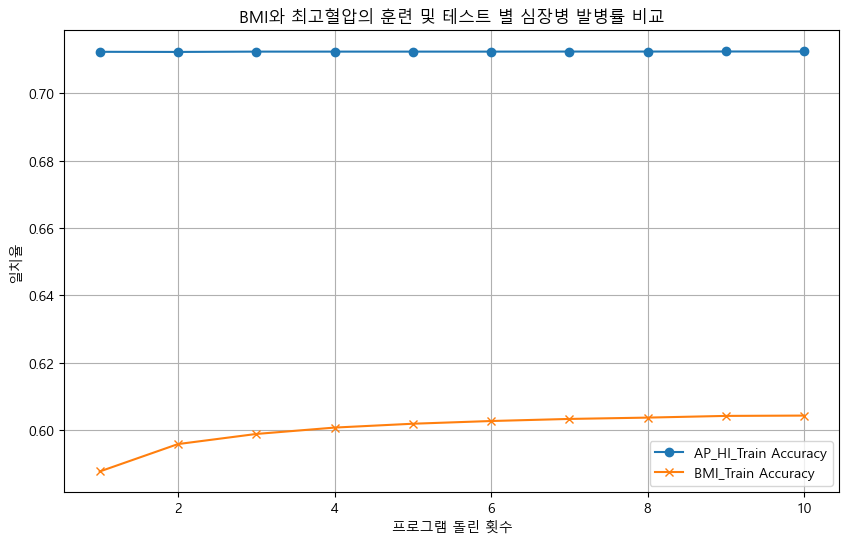

In [9]:
ap_hi_train_accuracies = []
ap_hi_test_accuracies = []
bmi_train_accuracies = []
bmi_test_accuracies = []
n_estimators_range = range(1, 11)

for n in n_estimators_range:
    modelX = RandomForestClassifier(n_estimators=n, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    modelX.fit(X_train, y_train)
    
    modelA = RandomForestClassifier(n_estimators=n, random_state=42)
    A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)
    modelA.fit(A_train, b_train)
    
    # 훈련 정확도와 테스트 정확도 계산
    ap_hi_train_accuracy = accuracy_score(y_train, modelX.predict(X_train))
    ap_hi_test_accuracy = accuracy_score(y_test, modelX.predict(X_test))
    bmi_train_accuracy = accuracy_score(b_train, modelA.predict(A_train))
    bmi_test_accuracy = accuracy_score(b_test, modelA.predict(A_test))
    
    ap_hi_train_accuracies.append(ap_hi_train_accuracy)
    ap_hi_test_accuracies.append(ap_hi_test_accuracy)
    bmi_train_accuracies.append(bmi_train_accuracy)
    bmi_test_accuracies.append(bmi_test_accuracy)
    scoresX = cross_val_score(modelX, X, y, cv=5)
    scoresA = cross_val_score(modelA, A, b, cv=5)
print(f"X_Accuracy : {accuracy_score(y_test, modelX.predict(X_test))}")
print(f"A_Accuracy : {accuracy_score(b_test, modelA.predict(A_test))}")
print("모델 X 교차 검증 평균 점수:", scoresX.mean())
print("모델 A 교차 검증 평균 점수:", scoresA.mean())
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, ap_hi_train_accuracies, label='AP_HI_Train Accuracy', marker='o')
plt.plot(n_estimators_range, ap_hi_test_accuracies, label='AP_HI_Test Accuracy', marker='o')
plt.plot(n_estimators_range, bmi_train_accuracies, label='BMI_Train Accuracy', marker='x')
plt.plot(n_estimators_range, bmi_test_accuracies, label='BMI_Test Accuracy', marker='x')
plt.xlabel("프로그램 돌린 횟수")
plt.ylabel("일치율")
plt.title("BMI와 최고혈압의 훈련 및 테스트 별 심장병 발병률 비교")
plt.legend()
plt.grid(True)

In [10]:
# Feature Importance (중요 변수 확인)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': modelX.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

feature_importances = pd.DataFrame({
    'Feature': A.columns,
    'Importance': modelA.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
  Feature  Importance
0   ap_hi        1.00

Feature Importances:
  Feature  Importance
0     bmi        1.00


In [17]:
# 3. Streamlit 앱
st.title('심장병 예측 시스템')
st.write('최고 혈압 값을 입력하여 심장병 예측을 해보세요.')

# 사용자 입력 받기
ap_hi = st.slider('ap_hi (최고혈압)', min_value=0, max_value=240, value=100)

# 예측하기 버튼
if st.button('예측하기'):
    # 입력값을 모델에 전달
    model = joblib.load('cardio.pkl')
    input_data = np.array([[ap_hi]])
    prediction = model.predict(input_data)[0]
    
    # 결과 출력
    if prediction == 1:
        st.write('예측 결과 : 심장병 가능성이 높습니다.')
    else:
        st.write('예측 결과 : 심장병 가능성이 낮습니다.')

2025-01-07 14:06:13.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.715 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.716 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-07 14:06:13.717 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [16]:
import pickle

df.to_pickle('cardio.pkl')

In [11]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)